In [1]:
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import os
import numpy as np
from datetime import datetime
import dateutil.relativedelta
import configparser

In [135]:
import requests
res = requests.get('https://telegram.org/')
print(res)

<Response [200]>


In [136]:
# %%capture
# %pip install -r requirements.txt
# !python -m nltk.downloader stopwords
# !python -m nltk.downloader wordnet
# !python -m nltk.downloader omw-1.4

In [2]:
if not os.path.exists('Last_Updated.txt'):
    last_updated_time = str(
        datetime.now() + dateutil.relativedelta.relativedelta(months=-1))
    CurrentYear,CurrentMonth,CurrentDate = [int(i) for i in last_updated_time.split(" ")[0].split("-")]
else:
    with open('Last_Updated.txt', 'r') as f:
        last_updated_time = f.read()
        CurrentYear,CurrentMonth,CurrentDate = [int(i) for i in last_updated_time.split(" ")[0].split("-")]

In [3]:
import ast
config = configparser.ConfigParser()
config.read_file(open('config.cfg'))
binance_coins= ast.literal_eval(config.get('Telegram', 'Coins'))
groups = ast.literal_eval(config.get('Telegram', 'Groups'))
print(groups)

['bestcryptotutor', 'binancefuturesignal', 'BitmexCourses', 'btctradingclub', 'coin_signals', 'CryptoClassicsVIP', 'CRYPTONOTESMOHSIN', 'cryptopapasignals', 'CryptoProfitCoach', 'cryptosignalalert', 'CryptoSignalCrazy', 'FedRussianInsiders', 'freebitmexsignals', 'godx_signals', 'QualitySignalsChannel', 'The_CryptoLogy_Signals', 'UltimateCryptoSignals']


In [7]:
import snscrape.modules.telegram as telegram
import pandas as pd

tweets_list = []
for i in groups:
    print(i)
    for x,tel in enumerate(telegram.TelegramChannelScraper(i).get_items()):
        y,m,d = [int(i) for i in str(tel.date).split(' ')[0].split('-')]
        if  (m<=CurrentMonth and d<=CurrentDate):
            break
        tweets_list.append([i,str(tel.date).split(' ')[0],str(tel.date).split(' ')[1].split('+')[0], tel.content])
    

bestcryptotutor
binancefuturesignal
BitmexCourses
btctradingclub
coin_signals
CryptoClassicsVIP
CRYPTONOTESMOHSIN
cryptopapasignals
CryptoProfitCoach
cryptosignalalert
CryptoSignalCrazy
FedRussianInsiders
freebitmexsignals
godx_signals
QualitySignalsChannel
The_CryptoLogy_Signals
UltimateCryptoSignals


In [11]:
tel_df = pd.DataFrame(tweets_list, columns=['Name','Date','Time','Text'])


KeyError: 'Cleaned Text'

In [15]:
def MoreCleaning(text):
    if(text!= None):
        str_en = text.encode("ascii", "replace").replace(b"?",b" ")
        str_de = str_en.decode()
        str_de = re.sub(' +', ' ', re.sub(r"([0-9]+(\.[0-9]+)?)",r" \1 ", str_de).strip())
        str_de = re.sub(r"\bStop\sLoss\b", "StopLoss", str_de,re.IGNORECASE)
        matches = re.findall(r"\btarget[s]?\b", str_de,re.IGNORECASE)
        if matches:
            return str_de
        else:
            return np.nan
        print(str_de)
        return str_de
tel_df["Text"] = tel_df["Text"].apply(MoreCleaning)


In [16]:
tel_df= tel_df.iloc[::-1]
tel_df

,Name,Date,Time,Text
4828,UltimateCryptoSignals,2023-02-26,14:50:57,NaN
4827,UltimateCryptoSignals,2023-02-26,14:51:13,NaN
4826,UltimateCryptoSignals,2023-02-27,06:52:12,NaN
4825,UltimateCryptoSignals,2023-02-27,06:53:12,NaN
4824,UltimateCryptoSignals,2023-02-27,07:23:36,NaN
...,...,...,...,...
4,bestcryptotutor,2023-03-23,11:15:12,Signal Type Future/SpotExchange BinanceCoin (D...
3,bestcryptotutor,2023-03-23,11:34:54,Signal Type Future/Spot Exchange Binance Coin ...
2,bestcryptotutor,2023-03-23,18:05:57,Signal Type Future/Spot Exchange Binance Coin ...
1,bestcryptotutor,2023-03-24,12:40:23,NaN


In [17]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
exclude.remove('.')
exclude.remove('-')
lemma = WordNetLemmatizer()
def text_cleaning(text):
    stop_free = ' '.join([word for word in str(text).split() if word not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = ' '.join([lemma.lemmatize(word) for word in punc_free.split()])
    return normalized.split()

tel_df["Cleaned Text"]= tel_df["Text"].apply(text_cleaning)

In [18]:
tel_df.groupby('Name').count()

,Date,Time,Text,Cleaned Text
Name,,,,
BitmexCourses,24,24,18,24
CRYPTONOTESMOHSIN,135,135,2,135
CryptoClassicsVIP,281,281,151,281
CryptoProfitCoach,17,17,2,17
CryptoSignalCrazy,11,11,1,11
FedRussianInsiders,209,209,38,209
QualitySignalsChannel,2545,2545,2545,2545
UltimateCryptoSignals,322,322,47,322
bestcryptotutor,42,42,33,42


In [20]:
os.chdir('C:\\Users\\Mohib\\Desktop\\Testing Channels')
if not os.path.exists('Channels'):
    os.mkdir('Channels')
os.chdir(os.path.join(os.getcwd(),'Channels'))
for i in groups:
    if not os.path.exists(i):
        os.mkdir(i)
    os.chdir(os.path.join(os.getcwd(),i))
    tel_df[tel_df['Name']==i].to_csv('0_'+i+'.csv', mode='w', index=False, header=False)
    os.chdir('C:\\Users\\Mohib\\Desktop\\Testing Channels\\Channels')
os.chdir("C:\\Users\\Mohib\\Desktop\\FinalYear\\Telegram")
with open('datetime.txt', 'w') as f:
    f.write(str(datetime.now()))

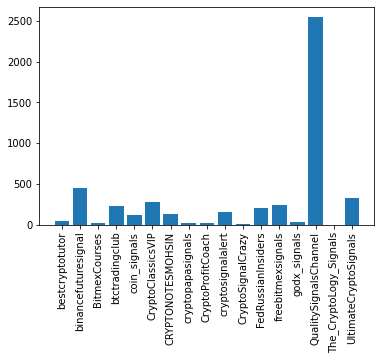

In [21]:
import pandas as pd
from matplotlib import pyplot as plt
count = []
names = []
for group in groups:
    names.append(group)
    count.append(len(tel_df[tel_df['Name']==group]))
plt.bar(names,count)
plt.xticks(rotation=90)
plt.show()

Before Filter 1

In [22]:
def extractor(i):
    i = str(i)
    suffixes = 'usdt|busd|futures'
    coinsregex = '|'.join(binance_coins)
    found = False
    text = re.sub(r'[^\w\s]', ' ', i)
    for s in text.split():
        if re.search("({})({})+|({})+({})|^({})$|[0-9]+({})|({})[0-9]+".format(coinsregex,suffixes,suffixes,coinsregex,coinsregex,coinsregex,coinsregex), s,re.IGNORECASE):
            found = True
            break
    if(found):
        return i
    else: return np.nan
tel_df['Cleaned Text'] = tel_df['Cleaned Text'].apply(extractor)
tel_df_fil1 = tel_df[tel_df['Cleaned Text'].notna()] 

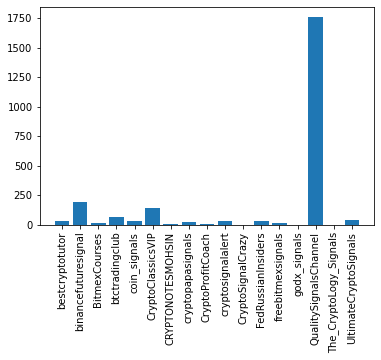

In [23]:
import pandas as pd
from matplotlib import pyplot as plt
count = list()
names = list()
for group in groups:
    names.append(group)
    count.append(len(tel_df_fil1[tel_df_fil1['Name']==group]))
plt.bar(names,count)
plt.xticks(rotation=90)
plt.show()

After Filter 1 

In [29]:
os.chdir('C:\\Users\\Mohib\\Desktop\\Testing Channels')
if not os.path.exists('Channels'):
    os.mkdir('Channels')
os.chdir(os.path.join(os.getcwd(),'Channels'))
for i in groups:
    if not os.path.exists(i):
        os.mkdir(i)
    os.chdir(os.path.join(os.getcwd(),i))
    tel_df_fil1[tel_df_fil1['Name']==i].to_csv('1_'+i+'.csv', mode='a', index=False, header=False)
    os.chdir('C:\\Users\\Mohib\\Desktop\\Testing Channels\\Channels')
os.chdir("C:\\Users\\Mohib\\Desktop\\FinalYear\\Telegram")
with open('datetime.txt', 'w') as f:
    f.write(str(datetime.now()))